In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%matplotlib inline

In [2]:
import psycopg2


postgresDb = psycopg2.connect(
    host="localhost",
    database="postgres",
    user="postgres",
    password="admin")

In [3]:
class Stockdatadao:
    def __init__(self, db):
        self.db = db

    def select(self, symbol):
        cursor = self.db.cursor()
        sql = """SELECT date_time, open, high, low, close, volume, adj_close
                    FROM stock_data WHERE symbol = %s"""
        val = (symbol,)

        cursor.execute(sql, val)
        result = cursor.fetchall()
        list_stock_data = []

        for item in result:
            list_stock_data.append(
                StockDataViewModel(date_time=item[0], open=item[1], high=item[2], low=item[3],
                                   close=item[4], volume=item[5], adj_close=item[6]))

        cursor.close()
        if result is None:
            return None
        else:
            return list_stock_data


class StockDataViewModel:
    def __init__(self, date_time, open, high, low, close, volume, adj_close):
        self.date_time = date_time
        self.open = open
        self.high = high
        self.low = low
        self.close = close
        self.volume = volume
        self.adj_close = adj_close

    def to_dict(self):
        return {
            'date_time': self.date_time,
            'open': self.open,
            'high': self.high,
            'low': self.low,
            'close': self.close,
            'volume': self.volume,
            'adj_close': self.adj_close
        }

In [4]:
stock_data_dao = Stockdatadao(postgresDb)

stock_data = stock_data_dao.select('AAPL')

df = pd.DataFrame([s.to_dict() for s in stock_data], columns=['date_time', 'open', 'high', 'low', 'close', 'volume', 'adj_close'])

df = df.rename(columns={'date_time': 'date'})

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df['volume'] = df['volume'].astype(float)
print(df.head(10))

                open      high       low     close       volume  adj_close
date                                                                      
1980-12-12  0.128348  0.128906  0.128348  0.128348  469033600.0   0.099584
1980-12-15  0.122210  0.122210  0.121652  0.121652  175884800.0   0.094388
1980-12-16  0.113281  0.113281  0.112723  0.112723  105728000.0   0.087461
1980-12-17  0.115513  0.116071  0.115513  0.115513   86441600.0   0.089625
1980-12-18  0.118862  0.119420  0.118862  0.118862   73449600.0   0.092224
1980-12-19  0.126116  0.126674  0.126116  0.126116   48630400.0   0.097852
1980-12-22  0.132254  0.132813  0.132254  0.132254   37363200.0   0.102614
1980-12-23  0.137835  0.138393  0.137835  0.137835   46950400.0   0.106945
1980-12-24  0.145089  0.145647  0.145089  0.145089   48003200.0   0.112573
1980-12-26  0.158482  0.159040  0.158482  0.158482   55574400.0   0.122964


In [5]:
###get the dataset of AAPL stock from 2013-01-01 to 2023-06-01 from df
df = df.loc['2013-01-01':'2023-06-29']

print(df.last('3D'))

                  open        high         low       close      volume  \
date                                                                     
2023-06-27  185.889999  188.389999  185.669998  188.059998  50730800.0   
2023-06-28  187.929993  189.899994  187.600006  189.250000  51216800.0   
2023-06-29  189.080002  190.070007  188.940002  189.589996  46126000.0   

             adj_close  
date                    
2023-06-27  188.059998  
2023-06-28  189.250000  
2023-06-29  189.589996  


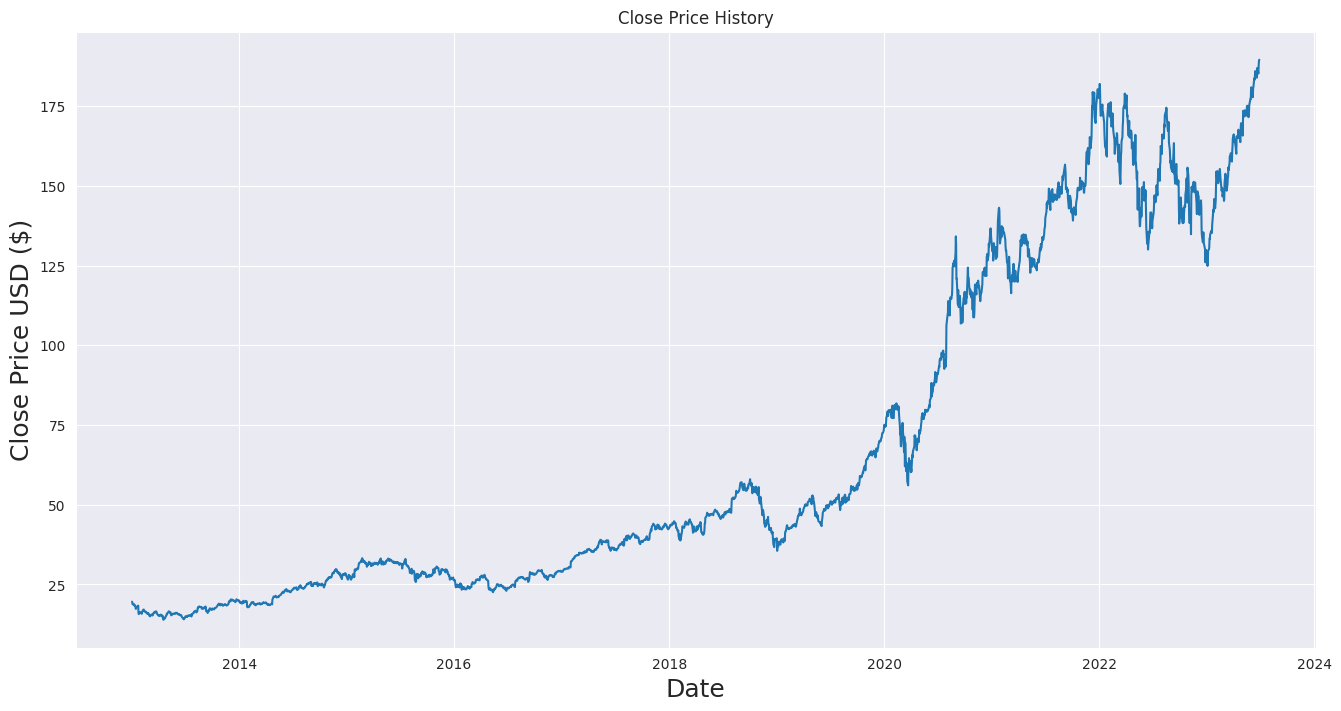

In [6]:
###plot the close price history of AAPL stock from 2013-01-01 to 2023-06-01 from df using matplotlib

plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [7]:
#adding a field to the data set for calculating the mean of high and low price in df

df['Mean'] = (df['high'] + df['low']) / 2.0

df.head(2)

,open,high,low,close,volume,adj_close,Mean
date,,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,560518000.0,16.813864,19.582679
2013-01-03,19.567142,19.631071,19.321428,19.360714,352965200.0,16.601629,19.476250


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2641 entries, 2013-01-02 to 2023-06-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2641 non-null   float64
 1   high       2641 non-null   float64
 2   low        2641 non-null   float64
 3   close      2641 non-null   float64
 4   volume     2641 non-null   float64
 5   adj_close  2641 non-null   float64
 6   Mean       2641 non-null   float64
dtypes: float64(7)
memory usage: 165.1 KB


In [9]:
#We need to restructure the data set by adding a target column ‘Actual’, which will the stock prices for the next day.

steps=-1
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual'] = dataset_for_prediction['Mean'].shift(steps)
dataset_for_prediction.head(3)

,open,high,low,close,volume,adj_close,Mean,Actual
date,,,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,560518000.0,16.813864,19.582679,19.476250
2013-01-03,19.567142,19.631071,19.321428,19.360714,352965200.0,16.601629,19.476250,19.008214
2013-01-04,19.177500,19.236786,18.779642,18.821428,594333600.0,16.139196,19.008214,18.651785


In [10]:
##dropping columns with null values in dataset_for_prediction

dataset_for_prediction = dataset_for_prediction.dropna()

Text(0.5, 1.0, ' Apple Stock Value')

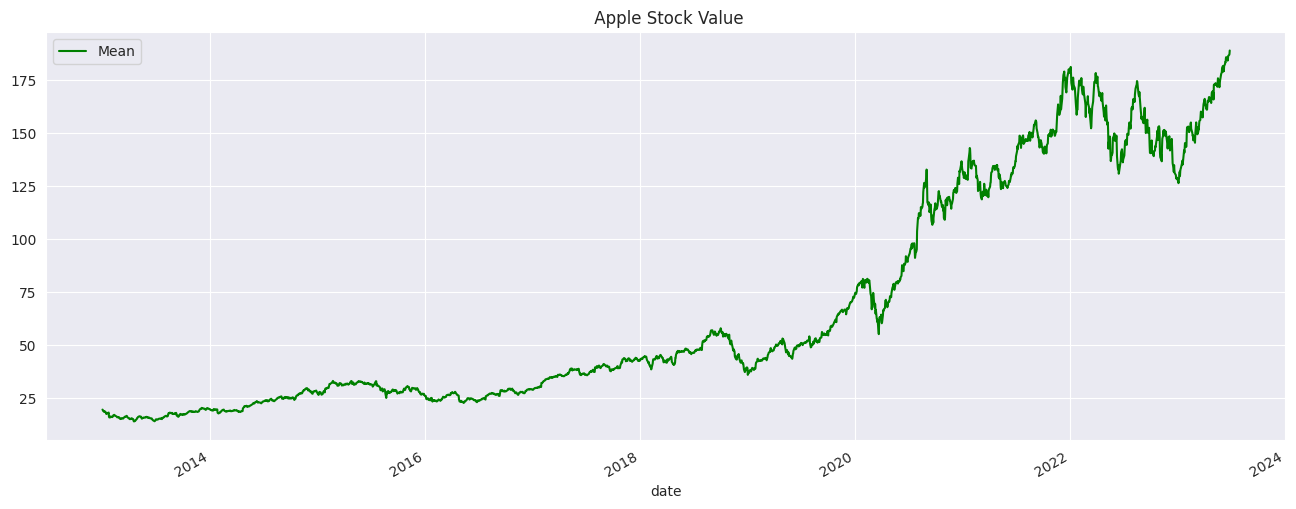

In [11]:
#plot the mean stock prices for the current dataset and lock the trends from df

dataset_for_prediction['Mean'].plot(color='green', figsize=(16, 6))
plt.legend(['Mean'])
plt.title(" Apple Stock Value")

Text(0.5, 1.0, ' Apple Stock Volume')

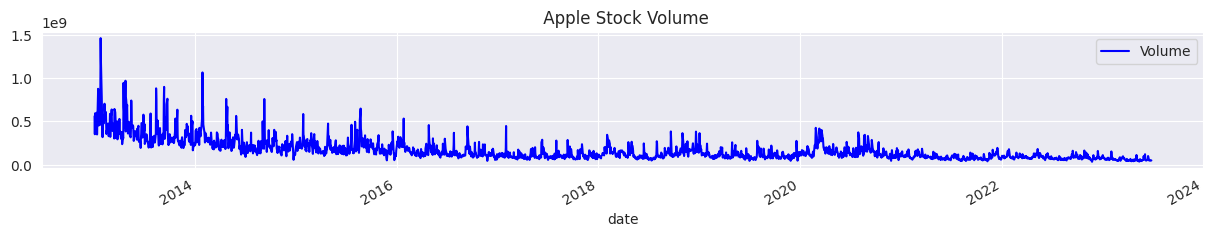

In [12]:
#Plotting volume of Apple stocks sold daily from df

dataset_for_prediction['volume'].plot(color='blue', figsize=(15, 2))
plt.legend(['Volume'])
plt.title(" Apple Stock Volume")

In [13]:
#Normalizing the input and target features
#Since the stock prices and volume are on a different scale, we need to normalize the data. We use MinMaxScaler; it will scale the data to a fixed range between 0 to 1
# Scaling the input features- Low, High, Open, Close, Volume, Adjusted Close, and Mean

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler.fit_transform(dataset_for_prediction[['low', 'high', 'open', 'close', 'volume', 'adj_close', 'Mean']])
scaled_input = pd.DataFrame(scaled_input)

X = scaled_input
X.head(2)

,0,1,2,3,4,5,6
0,0.032157,0.031601,0.034027,0.032291,0.368477,0.026996,0.031877
1,0.032027,0.030517,0.032808,0.030879,0.222893,0.025799,0.031268


In [14]:
#Scaling the target feature- Actual (Mean of High and Low) price

sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])

scaler_output = pd.DataFrame(scaled_output)

y = scaler_output
y.head(2)

,0
0,0.031134
1,0.028467


In [15]:
X.rename(columns={0: 'low', 1: 'high', 2: 'open', 3: 'close', 4: 'volume', 5: 'adj_close', 6: 'Mean'}, inplace=True)
X.index=dataset_for_prediction.index
X.head(2)

,low,high,open,close,volume,adj_close,Mean
date,,,,,,,
2013-01-02,0.032157,0.031601,0.034027,0.032291,0.368477,0.026996,0.031877
2013-01-03,0.032027,0.030517,0.032808,0.030879,0.222893,0.025799,0.031268


In [16]:
#renaming the target variable

y.rename(columns={0: 'Stock Price Next Day'}, inplace=True)
y.index=dataset_for_prediction.index

y.head(2)

,Stock Price Next Day
date,
2013-01-02,0.031134
2013-01-03,0.028467


In [17]:
#Splitting the dataset into training and testing sets

train_size = int(len(df) * 0.80)
test_size = int(len(df) - train_size)
print(test_size)

529


In [18]:
#Splitting the dataset into training and testing sets using train_size and test_size from df and y respectively
train_X, train_Y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_Y = X[train_size:].dropna(), y[train_size:].dropna()

In [19]:
test_X.columns

Index(['low', 'high', 'open', 'close', 'volume', 'adj_close', 'Mean'], dtype='object')

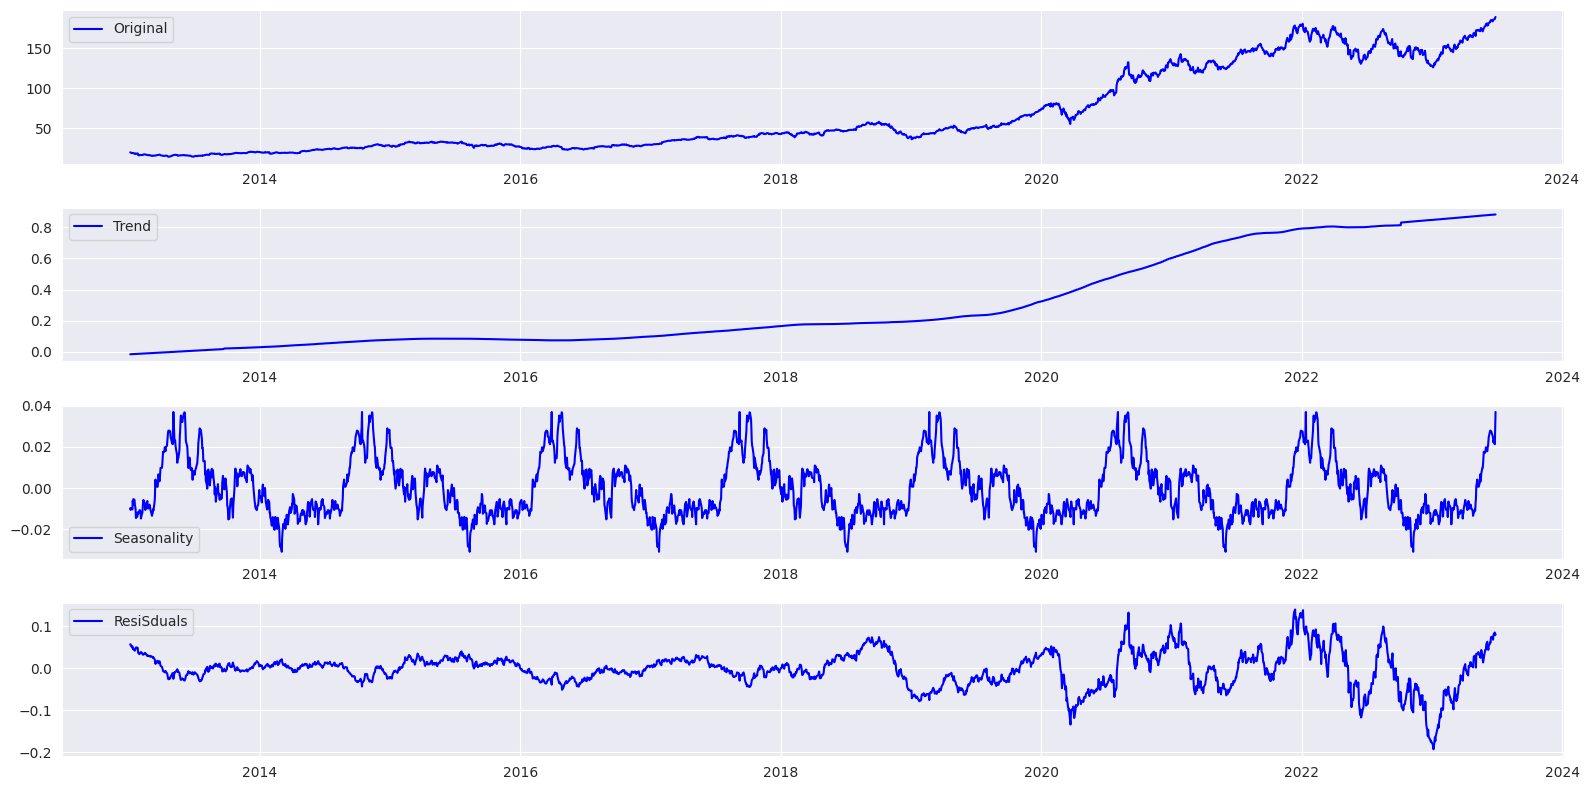

In [20]:
# ###Understanding the Time series data
# Decomposing Time Series into several components-Trend, Seasonality, and Random noise
#
# We know that Time series data is composed of Level, Trend, Seasonality, and Random noise. Let’s decompose the data and plot the trend, seasonality, and randomness in the data.
#
# We use statsmodel for seasonal decompose as an additive model and the frequency of the time series, which is the periodicity of the data, which is 365 days for yearly data.
#
# Additive model = Trend + Seasonality + Random Noise

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(X['Mean'], model='add', period=365, extrapolate_trend='freq', two_sided=True, filt=None)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(df['Mean'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='ResiSduals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [21]:
###Check for Data Stationarity using Augmented Dickey-Fuller(ADF) test.

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

def test_adf(series, title=''):
    dfout={}
    dftest = sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is  Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)


In [22]:
#Checking for stationarity in the data using the ADF test

y_test = y['Stock Price Next Day'][:train_size].dropna()
test_adf(y_test, 'Stock Price Next Day')

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Price Next Day


In [23]:
#Make the data stationary by differencing the data

y_test_diff = y_test.diff().dropna()
test_adf(y_test_diff, 'Stock Price Next Day')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is  Stationary
Data is Stationary Stock Price Next Day


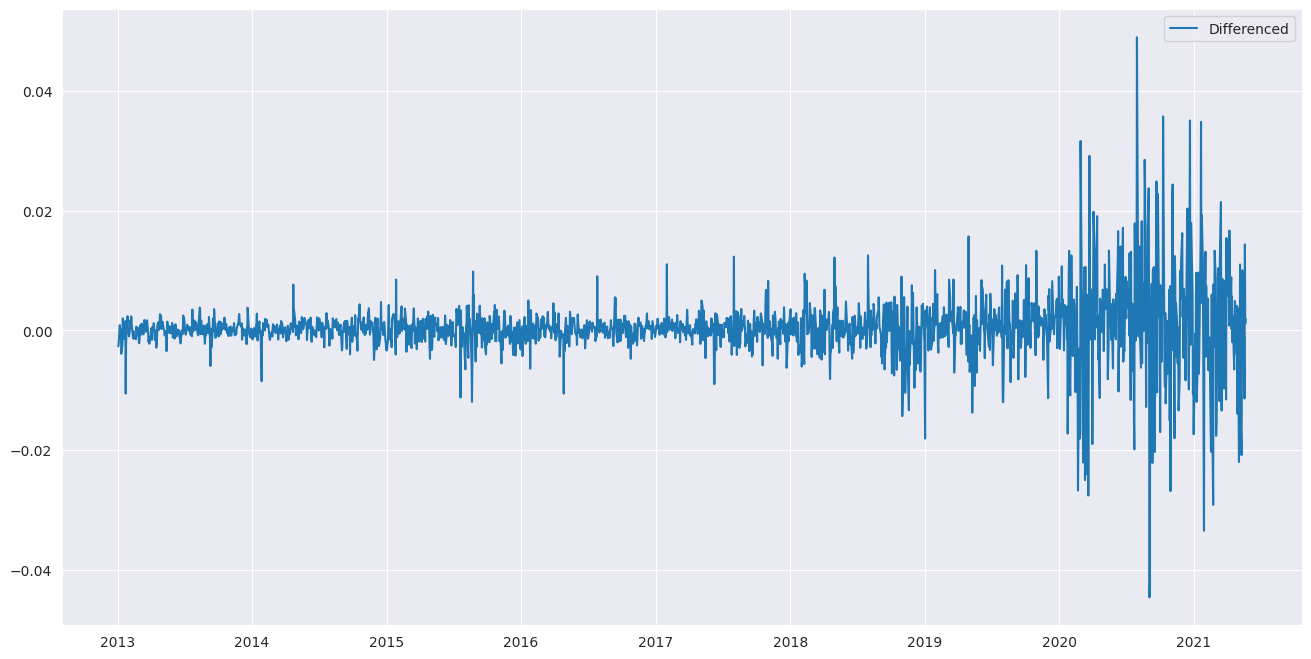

In [25]:
#Plotting the differenced data

plt.figure(figsize=(16, 8))
plt.plot(y_test_diff, label='Differenced')
plt.legend(loc='best')
plt.show()

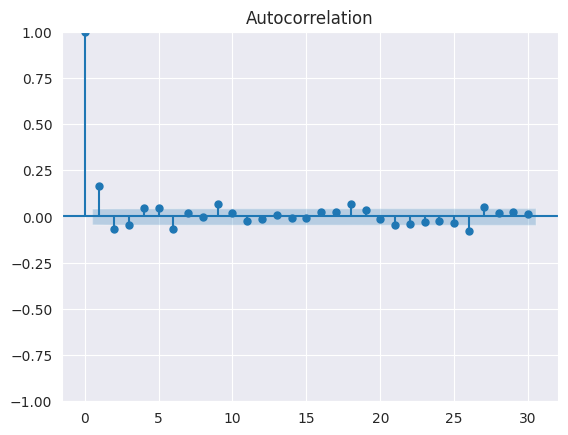

In [26]:
#Plotting the autocorrelation plot for the differenced data

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y_test_diff, lags=30)
plt.show()

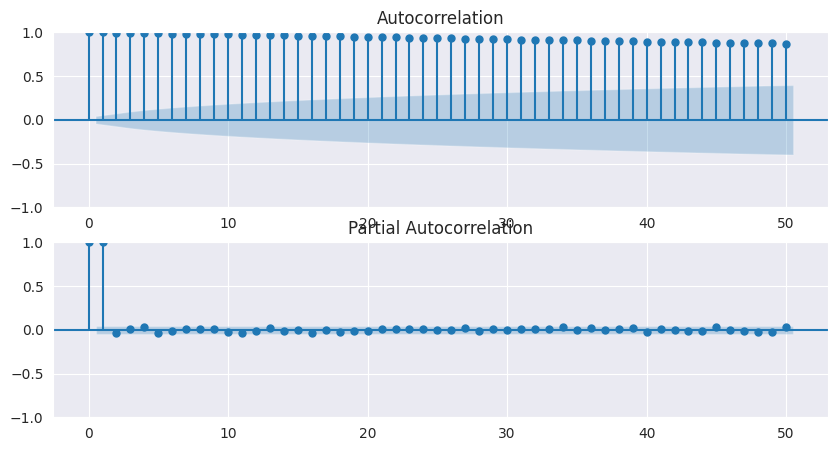

In [27]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [28]:
#Get the best parameters of seasonal orders for the SAIRMAX model using the auto_arima function from pmdarima library.

from pmdarima.arima import auto_arima

step_wise=auto_arima(train_Y, exogenous= train_X,
                       start_p=1, start_q=1,
                       max_p=7, max_q=7, m=12,
                       start_P=0, seasonal=True,
                       d=1, max_D=7, D=1, trace=True,
                       error_action='ignore',
                       suppress_warnings=True)

step_wise.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-15783.416, Time=2.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-14514.570, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-15158.148, Time=2.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-15783.913, Time=2.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-14586.606, Time=0.34 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-15783.281, Time=1.44 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=7.57 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-15163.242, Time=0.92 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=7.34 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=2.52 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-15783.989, Time=2.27 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=-14588.006, Time=0.35 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=9.89 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=inf, Time=10.23 sec
 ARIMA(0,1,2)(1,1,0)[12] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 2112
Model:             SARIMAX(0, 1, 3)x(1, 1, [1, 2], 12)   Log Likelihood                7955.745
Date:                                 Mon, 03 Jul 2023   AIC                         -15897.491
Time:                                         20:15:05   BIC                         -15857.946
Sample:                                              0   HQIC                        -15883.006
                                                - 2112                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1890      0.009     21.032      0.000       0.171       0.207
ma.L2         -0.0507      0.012     -4.225      0.000      -0.074      -0.027
ma.L3         -0.0703      0.012     -6.023      0.000      -0.093      -0.047
ar.S.L12      -0.5346      0.635     -0.841      0.400      -1.780       0.711
ma.S.L12      -0.3286      0.632     -0.520      0.603      -1.568       0.911
ma.S.L24      -0.4784      0.552     -0.867      0.386      -1.560       0.604
sigma2      2.965e-05    3.5e-07     84.816      0.000     2.9e-05    3.03e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             18910.54
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              21.55   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [145]:
#Fitting the model

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(endog=train_Y, exog=train_X, order=(0, 1, 3), seasonal_order=(1,1,2,12), enforce_invertibility=False, enforce_stationarity=False)

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Số lượng fold
n_splits = 5

# Khởi tạo KFold
kf = KFold(n_splits=n_splits)

cv_score = []

for train_index, test_index in kf.split(train_X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    y_train, y_test = train_Y.iloc[train_index], train_Y.iloc[test_index]
    model = SARIMAX(endog=y_train, exog=X_train, order=(0, 1, 3), seasonal_order=(1,1,2,12), enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit(maxiter=200, method='powell', disp=True, full_output=True)
    predictions = results.predict(start=test_index[0], end=test_index[-1], exog=X_test)
    error = mean_absolute_percentage_error(y_test, predictions)
    print('Mean Absolute Percentage Error: {:.2f}%'.format(error))
    cv_score.append(error)
    print("\n")

print("Mean CV Score: ",np.mean(cv_score))

Train Index:  [ 423  424  425 ... 2109 2110 2111] 

Test Index:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.725304
         Iterations: 9
         Function evaluations: 1444
Mean Absolute Percentage Error: 878113568455.50%


Train Index:  [   0    1    2 ... 2109 2110 2111] 

Test Index:  [423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458
 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548
 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566
 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584
 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602
 603 604 605 6

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.739632
         Iterations: 9
         Function evaluations: 1485
Mean Absolute Percentage Error: 0.56%


Train Index:  [   0    1    2 ... 2109 2110 2111] 

Test Index:  [ 846  847  848  849  850  851  852  853  854  855  856  857  858  859
  860  861  862  863  864  865  866  867  868  869  870  871  872  873
  874  875  876  877  878  879  880  881  882  883  884  885  886  887
  888  889  890  891  892  893  894  895  896  897  898  899  900  901
  902  903  904  905  906  907  908  909  910  911  912  913  914  915
  916  917  918  919  920  921  922  923  924  925  926  927  928  929
  930  931  932  933  934  935  936  937  938  939  940  941  942  943
  944  945  946  947  948  949  950  951  952  953  954  955  956  957
  958  959  960  961  962  963  964  965  966  967  968  969  970  971
  972  973  974  975  976  977  978  979  980  981  982  983  984  985
  986  987  988  989  990  991  992  993  994

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.736333
         Iterations: 6
         Function evaluations: 947
Mean Absolute Percentage Error: 0.90%


Train Index:  [   0    1    2 ... 2109 2110 2111] 

Test Index:  [1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1280 1281
 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294 1295
 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309
 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323
 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337
 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351
 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365
 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379
 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393
 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407
 1408 1409 1410 1411 1412 1413 1414 1415 1416 

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.768623
         Iterations: 6
         Function evaluations: 937
Mean Absolute Percentage Error: 1.54%


Train Index:  [   0    1    2 ... 1687 1688 1689] 

Test Index:  [1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 1701 1702 1703
 1704 1705 1706 1707 1708 1709 1710 1711 1712 1713 1714 1715 1716 1717
 1718 1719 1720 1721 1722 1723 1724 1725 1726 1727 1728 1729 1730 1731
 1732 1733 1734 1735 1736 1737 1738 1739 1740 1741 1742 1743 1744 1745
 1746 1747 1748 1749 1750 1751 1752 1753 1754 1755 1756 1757 1758 1759
 1760 1761 1762 1763 1764 1765 1766 1767 1768 1769 1770 1771 1772 1773
 1774 1775 1776 1777 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787
 1788 1789 1790 1791 1792 1793 1794 1795 1796 1797 1798 1799 1800 1801
 1802 1803 1804 1805 1806 1807 1808 1809 1810 1811 1812 1813 1814 1815
 1816 1817 1818 1819 1820 1821 1822 1823 1824 1825 1826 1827 1828 1829
 1830 1831 1832 1833 1834 1835 1836 1837 1838 

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -4.496014
         Iterations: 6
         Function evaluations: 922
Mean Absolute Percentage Error: 0.08%


Mean CV Score:  175622713691.71695


/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [31]:
from sklearn.metrics import mean_absolute_percentage_error
#Add cross validation to the model to check the accuracy of the model using the mean absolute percentage error

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX

tscv = TimeSeriesSplit(n_splits=5)

cv_score=[]

for train_index, test_index in tscv.split(train_X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    y_train, y_test = train_Y.iloc[train_index], train_Y.iloc[test_index]
    model = SARIMAX(endog=y_train, exog=X_train, order=(0, 1, 3), seasonal_order=(1,1,2,12), enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit(maxiter=200, method='powell', disp=True, full_output=True, start_ar_lags=2)
    predictions = results.predict(start=test_index[0], end=test_index[-1], exog=X_test)
    error = mean_absolute_percentage_error(y_test, predictions)
    print('Mean Absolute Percentage Error: {:.2f}%'.format(error))
    cv_score.append(error)
    print("\n")
print("Mean CV Score: ",np.mean(cv_score))

Train Index:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: start_ar_lags. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: -4.641687
         Iterations: 6
         Function evaluations: 957


/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A 

Mean Absolute Percentage Error: 0.07%


Train Index:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 2

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A 

Mean Absolute Percentage Error: 0.03%


Train Index:  [   0    1    2 ... 1053 1054 1055] 

Test Index:  [1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111
 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125
 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139
 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153
 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195
 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208 1209
 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223
 1224 1225 1226 1227 1228 1229 1230 1231 12

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A 

Mean Absolute Percentage Error: 0.02%


Train Index:  [   0    1    2 ... 1405 1406 1407] 

Test Index:  [1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421
 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434 1435
 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448 1449
 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462 1463
 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476 1477
 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487 1488 1489 1490 1491
 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503 1504 1505
 1506 1507 1508 1509 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519
 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533
 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547
 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559 1560 1561
 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575
 1576 1577 1578 1579 1580 1581 1582 1583 15

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A 

Mean Absolute Percentage Error: 0.05%


Train Index:  [   0    1    2 ... 1757 1758 1759] 

Test Index:  [1760 1761 1762 1763 1764 1765 1766 1767 1768 1769 1770 1771 1772 1773
 1774 1775 1776 1777 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787
 1788 1789 1790 1791 1792 1793 1794 1795 1796 1797 1798 1799 1800 1801
 1802 1803 1804 1805 1806 1807 1808 1809 1810 1811 1812 1813 1814 1815
 1816 1817 1818 1819 1820 1821 1822 1823 1824 1825 1826 1827 1828 1829
 1830 1831 1832 1833 1834 1835 1836 1837 1838 1839 1840 1841 1842 1843
 1844 1845 1846 1847 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857
 1858 1859 1860 1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871
 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885
 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899
 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913
 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927
 1928 1929 1930 1931 1932 1933 1934 1935 19

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
#Fitting the model

model = SARIMAX(endog=train_Y, exog=train_X, order=(0, 1, 3), seasonal_order=(1,1,2,12), enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()

In [ ]:
#Printing the summary of the model

results.summary()

In [ ]:
#Printing the model parameters

print(results.params)

In [ ]:
#Printing the model AIC value

print(results.aic)

In [ ]:
#Printing the model BIC value

print(results.bic)

In [ ]:
#Printing the model MSE value

print(results.mse)

In [ ]:
#Printing the model RMSE value

print(np.sqrt(results.mse))

In [ ]:
#Printing the model MAE value

print(results.mae)

In [ ]:
#Printing the model MAPE value

print(mean_absolute_percentage_error(train_Y, results.fittedvalues))

In [ ]:
#Printing the model MPE value

# print(mean_percentage_error(train_Y, results.fittedvalues))

In [ ]:
from pmdarima.metrics import smape

#Printing the model sMAPE value

print(smape(train_Y, results.fittedvalues))

In [ ]:
#Printing the model ACF value

print(results.plot_diagnostics())

In [ ]:
#Printing the model ACF value

print(results.plot_diagnostics())

In [ ]:
#Printing the model ACF value

print(results.plot_diagnostics())

In [ ]:
#Printing the model ACF value

print(results.plot_diagnostics())


In [160]:
#Predicting the values

predictions = results.predict(start=train_size, end=train_size+test_size+steps-1, exog=test_X)

#forcasting the value

forecast_1= results.forecast(steps=test_size-1, exog=test_X)

DatetimeIndex(['2021-05-24', '2021-05-25', '2021-05-26', '2021-05-27',
               '2021-05-28', '2021-06-01', '2021-06-02', '2021-06-03',
               '2021-06-04', '2021-06-07',
               ...
               '2023-06-14', '2023-06-15', '2023-06-16', '2023-06-20',
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26',
               '2023-06-27', '2023-06-28'],
              dtype='datetime64[ns]', name='date', length=528, freq=None)


/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [148]:
#Plotting the predicted values

act= pd.DataFrame(scaler_output.iloc[train_size:, 0])
# act.info()
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price Next Day']
predictions.rename(columns={0:'Pred'}, inplace=True)

<Axes: xlabel='date'>

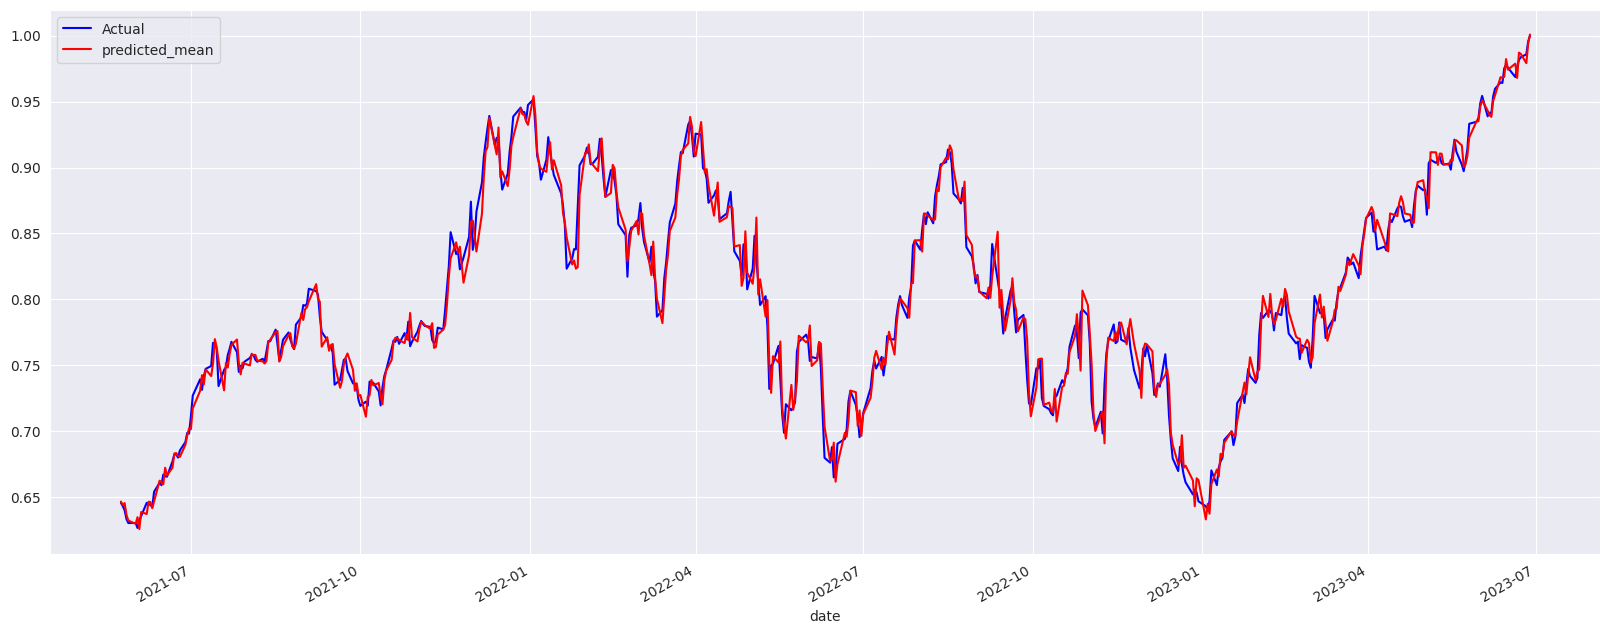

In [149]:
predictions["Actual"].plot(figsize=(20,8), legend=True, color="blue")
predictions["predicted_mean"].plot(legend=True, color="red", figsize=(20,8))

In [150]:
#Plotting the forecasted values

forecast_apple= pd.DataFrame(forecast_1)
forecast_apple.reset_index(drop=True, inplace=True)
forecast_apple.index=test_X.index
forecast_apple["Actual"] =scaler_output.iloc[train_size:, 0]
forecast_apple.rename(columns={0:"Forecast"}, inplace=True)

<Axes: xlabel='date'>

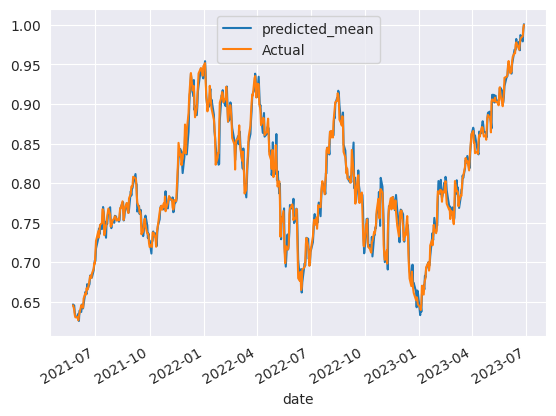

In [151]:
forecast_apple["predicted_mean"].plot(legend=True)
forecast_apple["Actual"].plot(legend=True)

In [152]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions["predicted_mean"], predictions["Actual"])
error

0.010941614482622692

In [162]:
start_date = '2023-07-03'
end_date = '2023-07-07'

# Predict for the specified date range
predictions = results.predict(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), exog=test_X)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'